In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

import multiprocessing
if __name__ == "__main__":
    multiprocessing.set_start_method("fork")
print("number of cpus =", multiprocessing.cpu_count())
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

no cupy 


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


number of cpus = 12


## Load data

In [3]:
h5filename = "/Volumes/RubbishBin/TDCII_Data/2_SingleSource_Dataset/data/MBHB_EOBv4opt_TDIXYZ.h5"
with h5py.File(h5filename, "r") as h5file:
    data_dict = read_dict_from_h5(h5file["/"])
data_dict.keys()

dict_keys(['XYZ', 'time'])

In [4]:
h5paramfilename = "/Volumes/RubbishBin/TDCII_Data/2_SingleSource_Dataset/data/MBHB_EOB4opt_parameters.h5"
with h5py.File(h5paramfilename, "r") as h5file:
    parameters = read_dict_from_h5(h5file["/"])
parameters.keys()

dict_keys(['chirp_mass', 'coalescence_phase', 'coalescence_time', 'inclination', 'latitude', 'longitude', 'luminosity_distance', 'mass_ratio', 'psi', 'spin_1z', 'spin_2z'])

In [5]:
channel_names = list(data_dict["XYZ"].keys())
data_channels = []
for ch in channel_names: 
    data_channels.append(data_dict["XYZ"][ch])
data_channels = np.array(data_channels)
data_time = data_dict["time"]
dt = data_time[1] - data_time[0]

data_time.shape, data_channels.shape 

((6294349,), (3, 6294349))

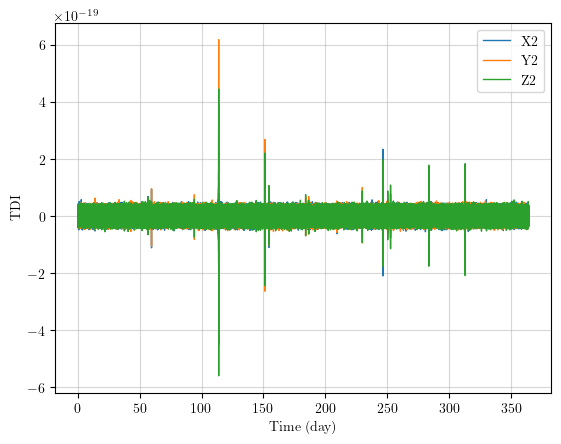

In [6]:
for ich, ch in enumerate(channel_names): 
    plt.plot(data_time/DAY, data_channels[ich], label=ch, linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper right")
plt.grid(linestyle="-", which="major", alpha=0.5)
plt.grid(linestyle=":", which="minor", alpha=0.4)

## Slice data 

In [7]:
T_analyze = 3 * DAY 
T_pad_before = 1 * DAY 
T_pad_end = 1 * DAY 

In [8]:
start_pad_time = 150. * DAY 
start_time = start_pad_time + T_pad_before
end_time = start_time + T_analyze
end_pad_time = end_time + T_pad_end 

idx_slice = np.where((data_time>=start_pad_time)&(data_time<=end_pad_time))[0]
time_slice = data_time[idx_slice]
data_slice = data_channels[:, idx_slice]

time_slice.shape, data_slice.shape, time_slice[0]/DAY, time_slice[-1]/DAY 

((86401,), (3, 86401), 150.0, 155.0)

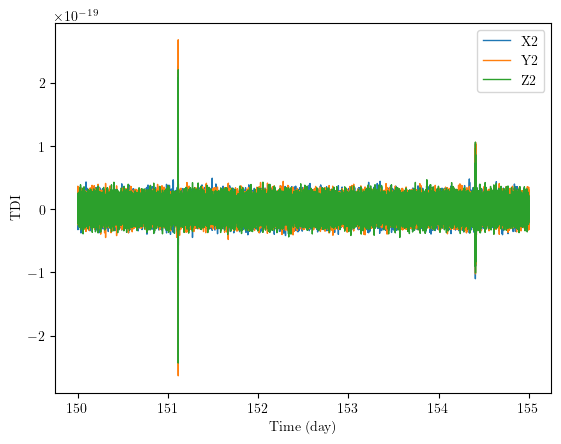

In [9]:
for ich, ch in enumerate(channel_names): 
    plt.plot(time_slice/DAY, data_slice[ich], label=ch, linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper right")

In [10]:
mbhb_idx = np.where((parameters["coalescence_time"]*DAY >= start_time)&(parameters["coalescence_time"]*DAY <= end_time))[0][0]
mbhb_parameters = dict()
for k, v in parameters.items():
    mbhb_parameters[k] = v[mbhb_idx]
mbhb_parameters

{'chirp_mass': 349189.88137340127,
 'coalescence_phase': 1.9585285727899828,
 'coalescence_time': 151.11697323182463,
 'inclination': 0.4975930973443147,
 'latitude': -0.4379021343671444,
 'longitude': 4.7724934757318005,
 'luminosity_distance': 98668.86453076257,
 'mass_ratio': 0.6495091828299151,
 'psi': 3.014868129826544,
 'spin_1z': 0.268061,
 'spin_2z': -0.394567}

## Signal model 

In [11]:
orbit = Orbit(OrbitDir="/Users/taijidatacenter/workspace/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB")
mbhb_waveform_generator = MBHB_Injection(approx_method="SEOBNRv4_opt", buffer=True)
mbhb_response_generator = FastMichelsonTDIResponse(
    orbit=orbit,
    tcb_times=time_slice.copy(), 
    # tcb_times=data_time.copy(),
    use_gpu=False, 
    drop_points=int(1000./dt), 
    interp_method="linear",
    # interp_method="Spline5",
    # interp_method="Akima",
)

## Matched filter
$$\rho_{D_L} = \frac{(d|h(\theta))}{\sqrt{(h(\theta)|h(\theta))}}, \quad D_L = \frac{(h(\theta)|h(\theta))}{(d|h(\theta))}$$

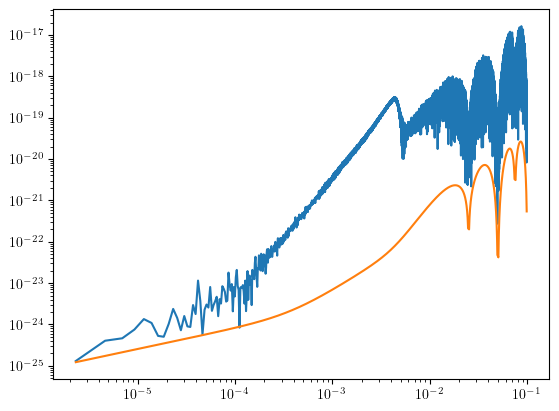

In [14]:
# fourier transform of data 
win_args = dict(window_type="tukey", window_args_dict=dict(alpha=0.05))
data_frequency, data_slice_fd = FFT_window(data_slice[0], fsample=1./dt, **win_args)
df = data_frequency[1] - data_frequency[0]

# remove null frequencies 
mask = np.ones_like(data_frequency, dtype=bool)
for i in range(1, 41):
    mask_idx = np.where(np.abs(data_frequency - i * 0.025) < 3e-4 * i)[0]
    mask[mask_idx] = False 
data_frequency = data_frequency[mask]
data_slice_fd = data_slice_fd[mask]

# calculate PSD at given arm length 
arms = dict()
for key in MOSA_labels: 
    arms[key] = float(orbit.LTTfunctions()[key](np.mean(time_slice)))
PSDfunc = TDIPSDs()
PSDdata = PSDfunc.PSD_X2_unequal(data_frequency, arms)

plt.loglog(data_frequency, np.abs(data_slice_fd) * 2. * data_frequency)
plt.loglog(data_frequency, np.sqrt(PSDdata * data_frequency))


In [15]:
from Triangle_BBH.Utils import ParamDict2ParamArr, ParamArr2ParamDict

def rho_dl(params): 
    params_full = np.zeros(11, dtype=np.float64)
    params_full[:6] = params[:6]
    params_full[7:] = params[6:] # lgdl = 0 -> dl = 1
    # print(ParamArr2ParamDict(params_full))
    template_td, _, _ = mbhb_response_generator(parameters=ParamArr2ParamDict(params_full), waveform_generator=mbhb_waveform_generator, optimal_combination=False)
    _, template_fd = FFT_window(template_td, fsample=1./dt, **win_args)
    template_fd = template_fd[mask]
    d_h_inner = np.sum(np.real(np.conjugate(data_slice_fd) * template_fd) / PSDdata * 4. * df) 
    h_h_inner = np.sum(np.abs(template_fd) ** 2 / PSDdata * 4. * df) 
    return d_h_inner / np.sqrt(h_h_inner)

def cost_function(params):
    return -rho_dl(params)

no cupy
No CuPy or GPU PhenomHM module.
has BBHx waveform


In [16]:
truths = ParamDict2ParamArr(mbhb_parameters)
truths = np.array(list(truths[:6]) + list(truths[7:]))
truths

array([  5.54306165,   0.64950918,   0.268061  ,  -0.394567  ,
       151.11697323,   1.95852857,   0.87873395,   4.77249348,
        -0.42404048,   3.01486813])

## Blind search in the time segment

In [17]:
from scipy.optimize import differential_evolution

bounds = [
    (5., 6.),
    (0.1, 1.),
    (-0.99, 0.99),
    (-0.99, 0.99),
    (start_time/DAY, end_time/DAY),
    (0, TWOPI), 
    (-1., 1.),
    (0, TWOPI), 
    (-1., 1.), 
    (0, PI),
]

result = differential_evolution(
    cost_function, 
    bounds=bounds,
    strategy='best1bin',    
    maxiter=2000,
    popsize=15,
    tol=1e-6, 
    mutation=(0.5, 1),    
    recombination=0.9, 
    workers=-1, 
    updating='deferred', 
    seed=42
)

result

             message: Optimization terminated successfully.
             success: True
                 fun: -378.87386357578856
                   x: [ 5.543e+00  6.041e-01  4.084e-01 -6.824e-01
                        1.511e+02  4.653e+00 -3.017e-01  3.210e+00
                       -2.183e-01  3.103e+00]
                 nit: 564
                nfev: 84959
          population: [[ 5.543e+00  6.041e-01 ... -2.183e-01  3.103e+00]
                       [ 5.543e+00  6.031e-01 ... -2.105e-01  3.127e+00]
                       ...
                       [ 5.543e+00  6.047e-01 ... -2.262e-01  3.082e+00]
                       [ 5.543e+00  6.029e-01 ... -2.170e-01  3.105e+00]]
 population_energies: [-3.789e+02 -3.789e+02 ... -3.789e+02 -3.789e+02]

In [18]:
def recover_params(params):
    params_full = np.zeros(11, dtype=np.float64)
    params_full[:6] = params[:6]
    params_full[7:] = params[6:] # lgdl = 0 -> dl = 1
    template_td, _, _ = mbhb_response_generator(parameters=ParamArr2ParamDict(params_full), waveform_generator=mbhb_waveform_generator, optimal_combination=False)
    _, template_fd = FFT_window(template_td, fsample=1./dt, **win_args)
    template_fd = template_fd[mask]
    d_h_inner = np.sum(np.real(np.conjugate(data_slice_fd) * template_fd) / PSDdata * 4. * df) 
    h_h_inner = np.sum(np.abs(template_fd) ** 2 / PSDdata * 4. * df) 
    dl = h_h_inner / d_h_inner
    recovered_params = ParamArr2ParamDict(params_full)
    recovered_params["luminosity_distance"] = dl 
    return recovered_params

In [19]:
np.array(ParamDict2ParamArr(recover_params(result.x))) - np.array(ParamDict2ParamArr(mbhb_parameters))

array([-5.00651350e-04, -4.54109226e-02,  1.40370912e-01, -2.87829152e-01,
        2.10723638e-04,  2.69453180e+00, -2.57558731e-01, -1.18043134e+00,
       -1.56203441e+00,  2.05784048e-01,  8.83417806e-02])

Text(0, 0.5, 'TDI')

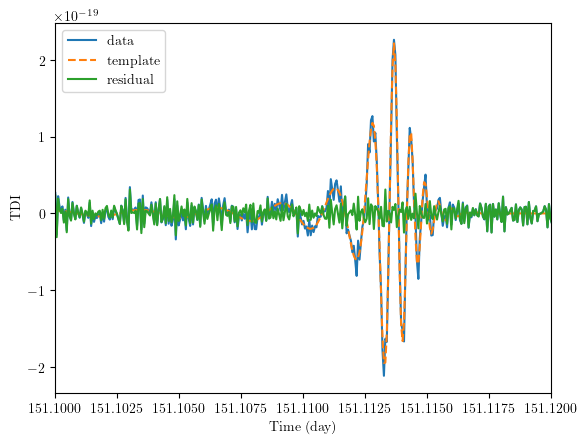

In [22]:
matched_template, _, _ = mbhb_response_generator(parameters=recover_params(result.x), waveform_generator=mbhb_waveform_generator, optimal_combination=False)
    
plt.plot(time_slice/DAY, data_slice[0], label="data")
plt.plot(time_slice/DAY, matched_template, linestyle="--", label="template")
plt.plot(time_slice/DAY, data_slice[0] - matched_template, label="residual")
plt.xlim(151.1, 151.12)
plt.legend(loc="upper left")
plt.xlabel("Time (day)")
plt.ylabel("TDI")

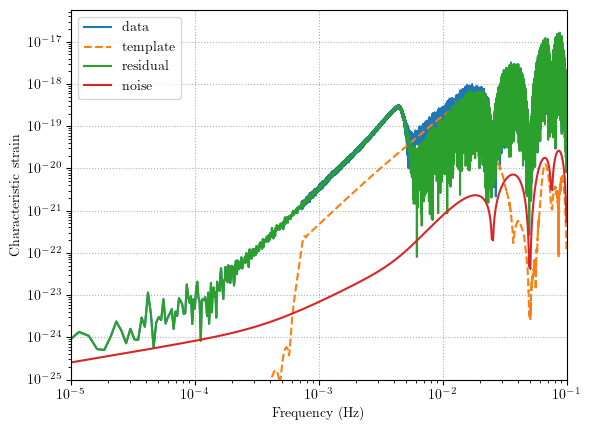

In [21]:
_, matched_template_fd = FFT_window(matched_template, 1./dt, **win_args)
matched_template_fd = matched_template_fd[mask]

plt.loglog(data_frequency, np.abs(data_slice_fd) * 2. * data_frequency, label="data")
plt.loglog(data_frequency, np.abs(matched_template_fd) * 2. * data_frequency, linestyle="--", label="template")
plt.loglog(data_frequency, np.abs(data_slice_fd - matched_template_fd) * 2. * data_frequency, label="residual")
plt.loglog(data_frequency, np.sqrt(PSDdata * data_frequency), label="noise")
plt.legend(loc="upper left")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strain")
plt.xlim(1e-5, 0.1)
plt.ylim(1e-25,)
plt.grid(linestyle=":")